In [7]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data_file = json.load(open("ultimate_data_challenge.json"))
data = pd.DataFrame(data_file)
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


* 'last_trip_date' and 'signup_date' need to be converted into strings or timestamps
* 'city, and 'phone' need to be converted into strings as categorical variables. For machine learning analyses, they need to be expanded into bionary variables.
* 'ultimate_black_user' need to be converted into a binary variable for machine learning methods

In [16]:
data.city = data.city.astype(str)
data.phone = data.phone.astype(str)

data.last_trip_date = data.last_trip_date.astype(str)
data.signup_date = data.signup_date.astype(str)

In [42]:
signup_timestamps = [pd.Timestamp(x) for x in data.signup_date]
# set the signup date as the index name
print(signup_timestamps.min(),'\n',signup_timestamps.max() )

2014-01-01T00:00:00.000000000 
 2014-01-31T00:00:00.000000000


### 1. Descriptive statistics and data wrangling

In [4]:
# summary statistics of the numerical variables
data.describe()

/Users/yizhao/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,NaN,NaN,1.000000,0.000000,0.000000,33.300000
50%,3.880000,NaN,NaN,1.000000,0.000000,1.000000,66.700000
75%,6.940000,NaN,NaN,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


* Average distance traveled has the highest range among all variables
* 'surge_pct' has a largest standard deviation relative to its mean value, about twice as much as the mean. 

                        avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
avg_dist                1.000000              0.080540              0.034509   
avg_rating_by_driver    0.080540              1.000000              0.123175   
avg_rating_of_driver    0.034509              0.123175              1.000000   
avg_surge              -0.081491              0.010597             -0.026189   
surge_pct              -0.104414              0.020103             -0.003899   
trips_in_first_30_days -0.136329             -0.039115             -0.011302   
ultimate_black_user     0.032310              0.009343             -0.002086   
weekday_pct             0.101652              0.020442              0.014630   

                        avg_surge  surge_pct  trips_in_first_30_days  \
avg_dist                -0.081491  -0.104414               -0.136329   
avg_rating_by_driver     0.010597   0.020103               -0.039115   
avg_rating_of_driver    -0.026189  -0.003899               -0.0

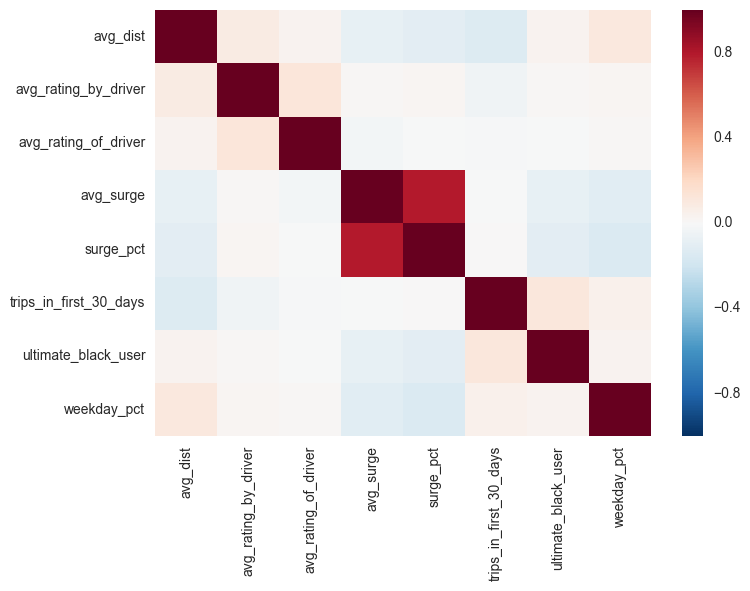

In [10]:
# visualize the amount of correlation among numeric variables

corr_matrix =data.corr()
print()
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)
plt.show()

#### Overall:
* 'surge_pct' and 'avg_surg' are highly correlated, which is expected given that they are the percent of trips taken with surge multiplier > 1 and the average surge multiplier over all of this user’s trips, respectively
* All other numeric variables have a correlation of less than 0.15 in absolute values

#### Positive correlations
* The 'average_rating_by_driver' is positively related with the 'average_rating_of_driver'. This is expected as the driver and passenger would have mutual perceptions of each other
* It is also interesting that trips that has a higher than average distance is more likely to have a higher rating both of driver and by driver. This is likely because a longer trip allows for more time to make meaningful conversations. 
* Ultimate black users are more likely to make a higher percentage of trips during the weekdays
* Users that are ultimate black users and or making a higher percentage of trips during the weekdays also appear to make on average both more trips ('trips_in_first_30_days') and longer distance trips ('avg_dist').

#### Negative correlations
* Users that make more trips are more likely to make shorter distance trips ('avg_dist' vs 'trips_in_first_30_days')
* The surge multiplier indicators are negatively correlated with 'avg_dist', 'trips_in_first_30_days', 'ultimate_black_users', 'weekday_pct'
* Users that make more trips in the first 30 days are more likely to make worse ratings either of driver or by driver. It could be that drivers that make more trips are more tired and less likely to entertain his/her riders, and frequent riders are first of all more likely to make shorter trips and then also likely to be bored or less interested in making conversations with drivers. 

Number of zero trip users: 15390


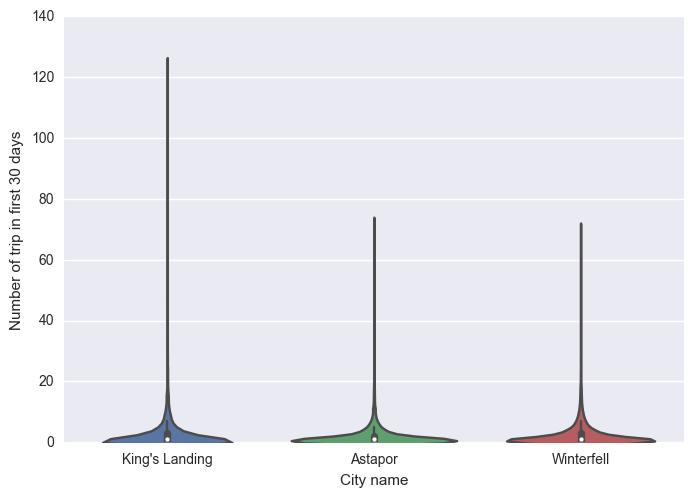

In [13]:
# plot the distribution of trips in first 30 days 
# categorized by phone, city
violin_city = sns.violinplot(y = data.trips_in_first_30_days, data= data,
                        x = data.city)
print('Number of zero trip users:', sum(data.trips_in_first_30_days==0))
axes = violin_city.axes

violin_city.set(xlabel= 'City name', 
                ylabel= 'Number of trip in first 30 days')
axes.set_ylim(0,)
plt.show()

* The distribution of number of trips made in the first 30 days is highly skewed to the left toward zero. 
* There are 15390 out of 50000 users being inactive, or made zero trips. That is 30.78% of our dataset. 
* King's Landing has a higher number of trips than Astapor and Winterfell on average.

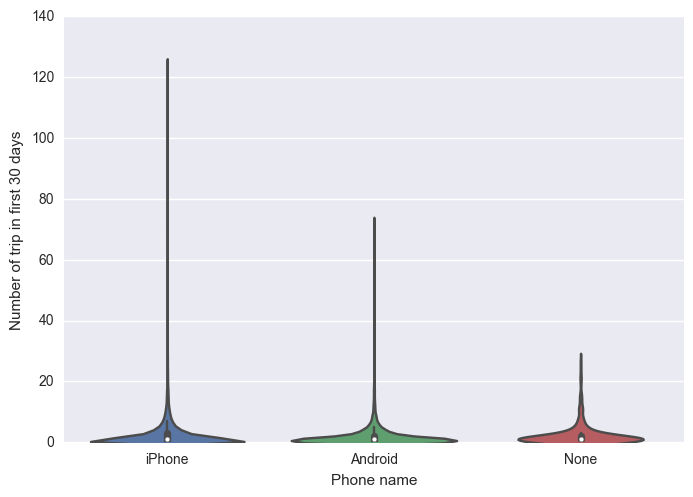

In [17]:
violin_phone = sns.violinplot(y = data.trips_in_first_30_days, data= data,
                        x = data.phone)
axes = violin_phone.axes

violin_phone.set(xlabel= 'Phone name', 
                ylabel= 'Number of trip in first 30 days')
axes.set_ylim(0,)
plt.show()

* Consecutively , the number of trips in the first 30 days is on average the highest among iPhone users , then followed by Android and other phone users. 

### Construct predictive model
* Since the goal is to distinguish inactive customers, a binary variable could indicate whether a user had at least one trip or not. 

In [63]:
X = data.copy().drop('trips_in_first_30_days', axis = 1)

# convert the boolean variable into a binary variable
X.ultimate_black_user = X.ultimate_black_user * 1

In [64]:
y = (data[['trips_in_first_30_days']] > 0) * 1 
y[:5] # this is the bianry dependent variable

,trips_in_first_30_days
0,1
1,0
2,1
3,1
4,1


In [40]:
pd.get_dummies(data.phone, prefix='phone').head()

,phone_Android,phone_None,phone_iPhone
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0


In [65]:
# convert binary variable into dummy variables
X = pd.concat([X, 
               pd.get_dummies(data.phone, prefix='phone').iloc[:,:-1]], 
              axis=1) # remove the last column in each dummy variable
X = pd.concat([X, 
               pd.get_dummies(data.city, prefix='city').iloc[:,:-1]], 
              axis=1)
X = X.drop(['phone', 'city'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                50000 non-null float64
avg_rating_by_driver    49799 non-null float64
avg_rating_of_driver    41878 non-null float64
avg_surge               50000 non-null float64
last_trip_date          50000 non-null object
signup_date             50000 non-null object
surge_pct               50000 non-null float64
ultimate_black_user     50000 non-null int64
weekday_pct             50000 non-null float64
phone_Android           50000 non-null float64
phone_None              50000 non-null float64
city_Astapor            50000 non-null float64
city_King's Landing     50000 non-null float64
dtypes: float64(10), int64(1), object(2)
memory usage: 5.0+ MB


In [66]:
X = X.drop(['last_trip_date', 'signup_date'], axis = 1)
# this feature overlaps with the predicted variable

X.shape

(50000, 11)

In [61]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation #StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import model_selection # StratifiedKFold

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from pandas_ml import ConfusionMatrix
import statsmodels.formula.api as sm

### Simple logistic regression using statsmodel

In [67]:
# add an intercept term for the model
X['intercept'] = 1.0

less_row = X.dropna(axis = 0 )
less_ft = X.dropna(axis = 1)

In [68]:
# split the dataset into a training and a testing set
seed = 1

X_train, X_test, y_train, y_test = train_test_split(less_ft, 
                                                y,
                                                random_state=seed)

In [58]:
print(X.shape, y.size)

(50000, 12) 50000


In [69]:
#define a logistic regression model and fit
logit_fit = sm.Logit(exog = X_train, endog = y_train).fit()

print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.611290
         Iterations 5
                             Logit Regression Results                             
Dep. Variable:     trips_in_first_30_days   No. Observations:                37500
Model:                              Logit   Df Residuals:                    37490
Method:                               MLE   Df Model:                            9
Date:                    Thu, 13 Apr 2017   Pseudo R-squ.:                0.009036
Time:                            15:03:13   Log-Likelihood:                -22923.
converged:                           True   LL-Null:                       -23132.
                                            LLR p-value:                 1.917e-84
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
avg_dist               -0.0264      0.002    -13.671      

* It seems that the surge indicators and percentage of weekday rides are not significant to whether users were active. In fact, only those that have been active could have those features computed. 
* Android phone also appears as insignificant, but it needs to remain in the model as it is a part of a categorical variable

In [73]:
# run the logistic regression again with less features
less_ft = less_ft.drop(['avg_surge', 'surge_pct', 'weekday_pct'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(less_ft, 
                                                y,
                                                random_state=seed)
logit = sm.Logit(exog = X_train, endog = y_train)
logit_fit = logit.fit()

print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.611355
         Iterations 5
                             Logit Regression Results                             
Dep. Variable:     trips_in_first_30_days   No. Observations:                37500
Model:                              Logit   Df Residuals:                    37493
Method:                               MLE   Df Model:                            6
Date:                    Thu, 13 Apr 2017   Pseudo R-squ.:                0.008930
Time:                            15:12:51   Log-Likelihood:                -22926.
converged:                           True   LL-Null:                       -23132.
                                            LLR p-value:                 4.152e-86
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
avg_dist               -0.0268      0.002    -13.959      

In [82]:
# run the logistic regression again with less rows from dropping NA
less_rows =pd.concat([X, y], axis = 1).dropna(axis = 0)
y_less = less_rows.iloc[:,-1].values.ravel()

less_rows = less_rows.drop(
    ['avg_surge', 'surge_pct', 'weekday_pct','trips_in_first_30_days'], 
    axis = 1)


In [83]:
X_train, X_test, y_train, y_test = train_test_split(less_rows, 
                                                y_less,
                                                random_state=seed)
logit = sm.Logit(exog = X_train, endog = y_train)
logit_fit = logit.fit()

print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.584328
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                31308
Model:                          Logit   Df Residuals:                    31299
Method:                           MLE   Df Model:                            8
Date:                Fri, 14 Apr 2017   Pseudo R-squ.:                0.009039
Time:                        10:36:29   Log-Likelihood:                -18294.
converged:                       True   LL-Null:                       -18461.
                                        LLR p-value:                 2.656e-67
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
avg_dist                -0.0275      0.002    -11.577      0.000        -0.032    -0.023

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    less_rows.drop(['avg_rating_by_driver'],axis = 1), 
                                                y_less,
                                                random_state=seed) 
logit = sm.Logit(exog = X_train, endog = y_train)
logit_fit = logit.fit()

print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.584351
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                31308
Model:                          Logit   Df Residuals:                    31300
Method:                           MLE   Df Model:                            7
Date:                Fri, 14 Apr 2017   Pseudo R-squ.:                0.009000
Time:                        11:19:17   Log-Likelihood:                -18295.
converged:                       True   LL-Null:                       -18461.
                                        LLR p-value:                 7.496e-68
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
avg_dist                -0.0277      0.002    -11.720      0.000        -0.032    -0.023

In [84]:
# use kfold cross validation to validate the results
kfold = cross_validation.StratifiedKFold(y_less, 
                                         n_folds=5, 
                                         random_state=seed) 

results = cross_val_score(LogisticRegression(C = 0.1),  
                          less_rows, y_less,  
                          cv=kfold,  
                          scoring = metrics.make_scorer(metrics.f1_score))
print('Less rows Logistic Regression Classifier\n mean f1_score: \n',
      results.mean())

Less rows Logistic Regression Classifier
 mean f1_score score: 
 0.838453617061


In [88]:
# use kfold cross validation to validate the results
y = y[['trips_in_first_30_days']].values.ravel()

kfold = cross_validation.StratifiedKFold(y, n_folds=5,  random_state=seed) 

results = cross_val_score(LogisticRegression(C = 0.1),  
                          less_ft, y,  
                          cv=kfold,  
                          scoring = metrics.make_scorer(metrics.f1_score))
print('Less Features Logistic Regression Classifier\n mean f1_score: \n',
      results.mean())

Less Features Logistic Regression Classifier
 mean f1_score: 
 0.817161323156


* Best performing logistic regressin model is using the following features:'avg_dist', 'ultimate_black_user', 'phone_None','city_Astapor', 'city_King's Landing', 'intercept'
* We shall attempt other ML methods with these features

In [97]:
#less_rows = less_rows.drop(['avg_rating_by_driver', 'phone_Android'], axis = 1)
less_rows.info()
print(len(y_less))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 7 columns):
avg_dist                41744 non-null float64
avg_rating_of_driver    41744 non-null float64
ultimate_black_user     41744 non-null int64
phone_None              41744 non-null float64
city_Astapor            41744 non-null float64
city_King's Landing     41744 non-null float64
intercept               41744 non-null float64
dtypes: float64(6), int64(1)
memory usage: 2.5 MB
41744


In [98]:
kfold = cross_validation.StratifiedKFold(y_less, 
                                         n_folds=5, 
                                         random_state=seed) 
results = cross_val_score(SVC(C = 0.1),  
                          less_rows, y_less,  
                          cv=kfold, scoring = metrics.make_scorer(metrics.f1_score))
print('Less rows SVM Classifier\n mean f1_score: \n',
      results.mean())

Less rows SVM Classifier
 mean f1_score: 
 0.838864009771


In [99]:
results = cross_val_score(SVC(C = 1),  
                          less_rows, y_less,  
                          cv=kfold, scoring = metrics.make_scorer(metrics.f1_score))
print('Less rows SVM Classifier\n mean f1_score: \n',
      results.mean())

Less rows SVM Classifier
 mean f1_score: 
 0.838515713476


* Changing the C parameter didn't make much difference
* The SVM result is very similar to that of the Logistic Regression, being both linear methods

In [100]:
a = 1.4837

def get_diff(a, b):
    return( 1/(1 + np.exp(- a - b)) - 1/(1 + np.exp(- a)))

print('avg_dist marginal change: ', get_diff(a,  -0.0277))

avg_dist marginal change:  -0.00421067078159


In [101]:
print('avg_rating_of_driver: ', get_diff(a,-0.0616 ))
# change in probability of being an active user from 
# increasing average rating of driver by 1

avg_rating_of_driver:  -0.00946337441883


In [102]:
print('ultimate_black_user: ', get_diff(a, 0.1936))

ultimate_black_user:  0.0274158820169


In [103]:
print('phone_None: ', get_diff(a, 0.3280))
# those that don't use smart phone has this much higer chance of being active users


phone_None:  0.0444364156535


In [104]:
print("City King's Landing: ", get_diff(a, logit_fit.params["city_King's Landing"]))
# those in King's Landing have 5.9 percentage points less probability of being active users

City King's Landing:  -0.0594211000538


#### Diagnostic of logistic regression

In [111]:
pred_train = logit_fit.predict(X_train)
pred_test = logit_fit.predict(X_test)

ConfusionMatrix(y_pred= (pred_train > 0.5) * 1, y_true= y_train)

Predicted   0      1  __all__
Actual                       
0          27   8631     8658
1          39  22611    22650
__all__    66  31242    31308

* There is a high number of false positives, or falsely predicted active users.